In [8]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, classification_report, f1_score

In [9]:
def trend_changes_score(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    return classification_report(y_df["is_changed_trend_test"][:-1], y_df["is_changed_trend_predict"][:-1], digits=4)

In [10]:
train_set = pd.read_csv("../../../data/training_set.csv")
validation_set = pd.read_csv("../../../data/validation_set.csv")
test_set = pd.read_csv("../../../data/test_set.csv")
final_data = pd.read_csv("../../../data/final_data.csv")

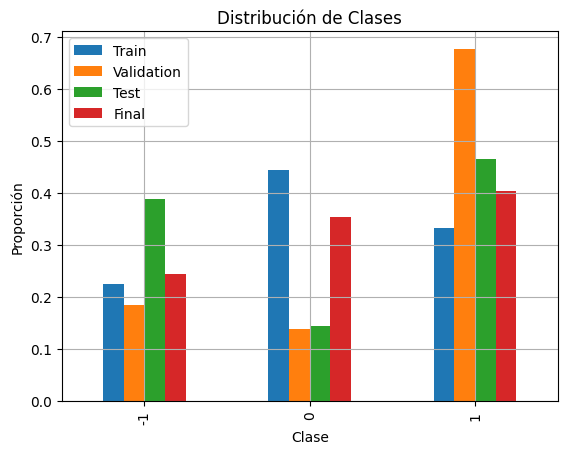

In [11]:
# Convertimos a DataFrame para facilitar la visualización

final_distribution = final_data['target_trend'].value_counts(normalize=True)
train_distribution = pd.Series(train_set['target_trend']).value_counts(normalize=True)
validation_distribution = pd.Series(validation_set['target_trend']).value_counts(normalize=True)
test_distribution = pd.Series(test_set['target_trend']).value_counts(normalize=True)

# Comparar visualmente
df = pd.DataFrame({
    'Train': train_distribution,
    'Validation': validation_distribution,
    'Test': test_distribution,

    'Final': final_distribution
    
}).fillna(0)

df.plot(kind='bar', title='Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Proporción')
plt.grid(True)
plt.show()

In [12]:
y_validation = validation_set['target_trend']
y_pred = validation_set['trend_d0']

In [13]:
report = classification_report(y_validation, y_pred, digits=4)
print(f"NaiveModel report:\n {report}")
print("Balanced accuracy:", balanced_accuracy_score(y_validation, y_pred))

NaiveModel report:
               precision    recall  f1-score   support

          -1     0.8750    0.8750    0.8750        24
           0     0.5263    0.5556    0.5405        18
           1     0.9425    0.9318    0.9371        88

    accuracy                         0.8692       130
   macro avg     0.7813    0.7875    0.7842       130
weighted avg     0.8724    0.8692    0.8708       130

Balanced accuracy: 0.7874579124579125


In [14]:
print(trend_changes_score(y_test=y_validation, y_pred=y_pred))

              precision    recall  f1-score   support

       False     0.8661    0.8661    0.8661       112
        True     0.1176    0.1176    0.1176        17

    accuracy                         0.7674       129
   macro avg     0.4919    0.4919    0.4919       129
weighted avg     0.7674    0.7674    0.7674       129

